## Modules à importer

In [2]:
import math
import scipy
import pickle
import astropy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [3]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [4]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles à mettre dans le _pandas_

In [5]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

gen.set_data(df[df['survey'] == 'PS1'])
assymPS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SDSS'])
assymSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
assymSNLS = gen.fit()

gen.set_data(df[df['survey'] == 'SNF'])
assymSNF = gen.fit()

gen.set_data(df[df['survey'] == 'HST'])
assymHST = gen.fit()

gen.set_data(df)
assymTOT = gen.fit()

gen.set_data(df[df['survey'].isin(['SDSS','PS1','SNLS','HST'])])
assymTOT_nsnf = gen.fit()

## Modèle _base_ pour comparaison

In [18]:
gen.set_model('Evol3G2M2SSNF')
gen.set_data(df[df['survey'] == 'SNF'])
base = gen.fit()

## Modèles BaseSURVEY

In [26]:
gen.set_model('Evol3G2M2S')

gen.set_data(assymSDSS.pd)
baseSDSS = gen.fit()

gen.set_data(assymPS1.pd)
basePS1 = gen.fit()

gen.set_data(assymSNLS.pd)
baseSNLS = gen.fit()

gen.set_data(assymHST.pd)
baseHST = gen.fit()

gen.set_data(assymTOT.pd)
baseTOT = gen.fit()

gen.set_data(assymTOT_nsnf.pd)
baseTOT_nsnf = gen.fit()

## Modèle Base-$\sigma_2$

In [27]:
gen.set_model('Evol3G2M1S')

gen.set_data(assymTOT_nsnf.pd)
base1STOT_nsnf = gen.fit()

gen.set_data(assymTOT.pd)
base1STOT = gen.fit()

In [29]:
print('AICc baseTOT_nsnf =', baseTOT_nsnf.get_aicc())
print('AICc base1STOT_nsnf =', base1STOT_nsnf.get_aicc())
print('AICc assymTOT_nsnf =', assymTOT_nsnf.get_aicc())

print('AICc baseTOT =', baseTOT.get_aicc())
print('AICc base1STOT =', base1STOT.get_aicc())
print('AICc assymTOT =', assymTOT.get_aicc())

AICc baseTOT_nsnf = 1190.8223690525222
AICc base1STOT_nsnf = 1190.0391174364456
AICc assymTOT_nsnf = 1189.9446559344656
AICc baseTOT = 1466.7981455125625
AICc base1STOT = 1464.948567324608
AICc assymTOT = 1491.2637595204537


## Another table comp

In [22]:
modelsa = [assymSDSS, assymPS1, assymSNLS, assymHST, assymSNF]
modelsb = [baseSDSS, basePS1, baseSNLS, baseHST, base]
param_sco = [[1.142, 1.652, 0.104], [0.384, 0.987, 0.505], [0.974, 1.236, 0.283]]

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

comp_L = pd.DataFrame({'#Data': [len(k.pd) for k in modelsa] +\
                       [np.sum([len(k.pd) for k in modelsa])] +\
                       [np.sum([len(k.pd) for k in modelsa[:-1]])],
                       'Survey': ['SDSS', 'PS1', 'SNLS', 'HST', 'SNf', 'Total', 'Total-SNf'],
                       '$\mathcal{L}$ asym (this)': [round(k.get_logl(),1) for k in modelsa] +\
                       [round(np.sum([k.get_logl() for k in modelsa]),1)] +\
                       [round(np.sum([k.get_logl() for k in modelsa[:-1]]),1)],
                       'Free param ': [len(k.FREEPARAMETERS) for k in modelsa] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-1]])],
                       '$\mathcal{L}$ Base SNf': [round(k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']),1) for k in modelsb] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb]),1)] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb[:-1]]),1)],
                       'Free param': [0, 0, 0, 0, 5,
                                      5,
                                      0],
                       '$\mathcal{L}$ asym Sco': [round(k.loglikelihood(p[0], p[1], p[2]),1) for k,p in zip(modelsa, param_sco)] + ['--'] + ['--']+\
                       ['--'] +\
                       [round(np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1)],
                      })

comp_A = pd.DataFrame({'#Data': [len(k.pd) for k in modelsa] +\
                       [np.sum([len(k.pd) for k in modelsa])] +\
                       [np.sum([len(k.pd) for k in modelsa[:-1]])] +\
                       [np.sum([len(k.pd) for k in modelsa[:-2]])],
                       'Survey': ['SDSS', 'PS1', 'SNLS', 'HST', 'SNf',
                                  'Total',
                                  'Total-SNf',
                                  'Total-SNf-HST'],
                       'AICc asym (this)': [round(k.get_aicc(),1) for k in modelsa] +\
                       [round(2*15 + (2*15*16)/(np.sum([len(k.pd) for k in modelsa])-16) + np.sum([k.get_logl() for k in modelsa]),1)] +\
                       [round(2*12 + (2*12*13)/(np.sum([len(k.pd) for k in modelsa[:-1]])-13) + np.sum([k.get_logl() for k in modelsa[:-1]]),1)] +\
                       [round(2*9 + (2*9*10)/(np.sum([len(k.pd) for k in modelsa[:-2]])-10) + np.sum([k.get_logl() for k in modelsa[:-2]]),1)],
                       'Free param ': [len(k.FREEPARAMETERS) for k in modelsa] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-1]])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-2]])],
                       'AICc Base SNf': [round(k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']),1) for k in modelsb[:-1]] + [round(base.get_aicc(),1)] +\
                       [round(2*5 + (2*5*6)/(np.sum([len(k.pd) for k in modelsb])-6) + np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb]),1)] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb[:-1]]),1)] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb[:-2]]),1)],
                       'Free param': [0, 0, 0, 0, 5,
                                      5,
                                      0,
                                      0],
                       'AICc asym Sco': [round(2*3 + (2*3*(3+1))/(len(k.pd)-3-1) + k.loglikelihood(p[0], p[1], p[2]),1) for k,p in zip(modelsa, param_sco)] + [80.8] + [305.5] +\
                       [round(2*15 + (2*15*16)/(np.sum([len(k.pd) for k in modelsa])-16) + np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1) + 73.7 + 299.3] +\
                       [round(2*12 + (2*12*13)/(np.sum([len(k.pd) for k in modelsa[:-1]])-13) + np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1) + 73.7] +\
                       [round(2*9 + (2*9*10)/(np.sum([len(k.pd) for k in modelsa[:-2]])-10) + np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1)],
                       ' Free param ': [len(k.FREEPARAMETERS) for k in modelsa] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-1]])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-2]])],
                      })

In [23]:
#path = '../Data/asym_comp_L'
#if cons.value:
#    path += '_cons'
#path += '.dat'
#comp_L.to_csv(path)

comp_L

,#Data,Survey,$\mathcal{L}$ asym (this),Free param,$\mathcal{L}$ Base SNf,Free param,$\mathcal{L}$ asym Sco
0,167,SDSS,445.0,3,452.9,0,457.9
1,160,PS1,397.4,3,405.2,0,397.6
2,102,SNLS,252.7,3,269.5,0,254.5
3,26,HST,73.7,3,75.9,0,--
4,114,SNf,299.3,3,268.6,5,--
5,569,Total,1468.2,15,1472.0,5,--
6,455,Total-SNf,1168.9,12,1203.4,0,1110


In [24]:
#path = '../Data/asym_comp_A'
#if cons.value:
#    path += '_cons'
#path += '.dat'
#comp_A.to_csv(path)

comp_A

,#Data,Survey,AICc asym (this),Free param,AICc Base SNf,Free param,AICc asym Sco,Free param
0,167,SDSS,451.2,3,452.9,0,464.0,3
1,160,PS1,403.6,3,405.2,0,403.7,3
2,102,SNLS,259.0,3,269.5,0,260.8,3
3,26,HST,80.8,3,75.9,0,80.8,3
4,114,SNf,305.5,3,279.1,5,305.5,3
5,569,Total,1499.0,15,1482.1,5,1513.8,15
6,455,Total-SNf,1193.6,12,1203.4,0,1208.4,12
7,429,Total-SNf-HST,1113.6,9,1127.5,0,1128.4,9


In [29]:
gen.set_model('Evol3G2M2S')
gen.set_data(df)
base_all = gen.fit()
base_all.get_aicc()-[round(2*15 + (2*15*16)/(np.sum([len(k.pd) for k in modelsa])-14) + np.sum([k.get_logl() for k in modelsa]),1)][0]

print(base_all.get_aicc()-(457.9+397.6+254.5+73.7+299.3 + 2*15 + (2*15*16)/((np.sum([len(k.pd) for k in modelsa])-16))))

-47.069847254164415


### Définition likelihood generic

In [8]:
def assym_law_gen(x, param):
    return(assymPS1.likelihood_tot(x, np.zeros(len(x)), param[0], param[1], param[2]))

# PS1

## Définition de _cov_ pour sélection aléatoire des paramètres

In [9]:
cov_PS1 = im.Minuit.matrix(assymPS1.m_tot)
mean_PS1 = [assymPS1.m_tot.values[i] for i in range(3)]
param_hesse_mat_PS1 = scipy.stats.multivariate_normal.rvs(mean=mean_PS1, cov=cov_PS1, size=500)

### List of all the models

In [10]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_PS1 = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_PS1]
models_hesse_PS1 = np.asarray(models_hesse_PS1)

### Take _std_

In [11]:
models_std_PS1 = np.std(models_hesse_PS1, axis=0)

## Tracé

In [19]:
p_sco = {'SDSS': [1.142, 1.652, 0.104],
         'PS1': [0.384, 0.987, 0.505],
         'SNLS': [0.974, 1.236, 0.283]}

def plot_pdfs(surveyname, color_p ="C2", color_s="0.2", perc_zmin=5, perc_zmax=95,
              ticks_size=12, show_legend=False,
              lw_col=2, lw_mod=2, lw_sco=2, ls_col='-', ls_mod='-', ls_sco='--'):
    fig = plt.figure(figsize=[6, 4])
    ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
    
    x_linspace = np.linspace(-3, 3, 3000)
    
    pdf_surv = pdfS(x_linspace) if surveyname == 'SDSS' else pdfP(x_linspace) if surveyname == 'PS1' else pdfN(x_linspace)
    
    ax.plot(x_linspace,
            pdf_surv,
            color=color_p,
            lw=lw_mod, ls=ls_mod,
            label=surveyname)
    
    models_std_surv = eval('models_std_%s'%surveyname)
    
    ax.fill_between(x_linspace,
                    pdf_surv + models_std_surv,
                    pdf_surv - models_std_surv,
                    color=color_p,
                    lw=1, alpha=.2)
    
    ax.vline(eval('assym%s'%surveyname).param['mu'], ymin=0, ymax=np.max(pdf_surv),
             color=color_p, alpha=.5, linewidth=2.0)
    
    mu_s = p_sco[surveyname][0]
    sigma_m_s = p_sco[surveyname][1]
    sigma_p_s = p_sco[surveyname][2]
    
    pdf_SCO = eval('assym%s'%surveyname).likelihood_tot(x_linspace,
                                      np.zeros(len(x_linspace)),
                                      mu_s,
                                      sigma_m_s,
                                      sigma_p_s)
    
    ax.plot(x_linspace,
            pdf_SCO,
            color=color_s, label='Scolnic',
            lw=lw_sco, ls=ls_sco)
    
    ax.vline(mu_s, 0, np.max(pdf_SCO),
             color=color_s, alpha=.5, linewidth=2.0)
    
    dgmap = plt.cm.get_cmap('coolwarm')
    nb_base = len(surv[surveyname].zCMB)
    i = 0
    
    z_m, z_p = np.percentile(surv[surveyname].zCMB, [perc_zmin, perc_zmax])
    
    for z in surv[surveyname].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
        pdf = base.likelihood_tot(base.delta(z),
                                  x_linspace, np.zeros(len(x_linspace)),
                                  base.param['aa'],
                                  base.param['mu_1'], base.param['sigma_1'],
                                  base.param['mu_2'], base.param['sigma_2'])
    
        ax.plot(x_linspace,
                np.max(pdf_surv)/np.max(pdf)*pdf,
                color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
                lw=lw_col, ls=ls_col)
        i += 1
     
    ax.set_xlim([-3, 3])
    ax.set_ylim([0, np.max(pdf_surv+models_std_surv)+0.01])
                                                                          
    ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
    ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')
    
    ax.tick_params(labelsize=ticks_size)
    
    if show_legend:
        ax.legend(ncol=1, loc='upper right')
    
    return(fig)

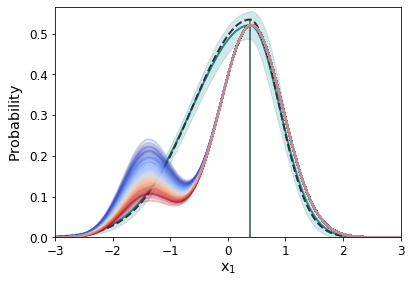

In [23]:
fig = plot_pdfs('PS1', color_p=colors['PS1'], ticks_size=12)
fig.savefig('../../../Images/bbc_comp_PS1.pdf', bbox_inches='tight')

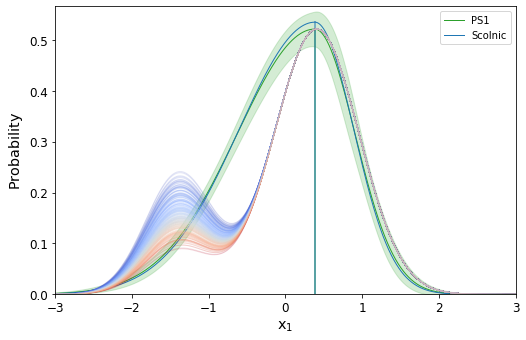

In [22]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymPS1.param['mu']

color_p = "C2"

pdf_PS1 = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymPS1.param['mu'],
                                  assymPS1.param['sigma_m'],
                                  assymPS1.param['sigma_p'])

ax.plot(x_linspace,
        pdf_PS1,
        color=color_p,
        lw=1, label='PS1')

ax.fill_between(x_linspace,
                pdf_PS1 + models_std_PS1,
                pdf_PS1 - models_std_PS1,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymPS1.param['mu'], ymin=0, ymax=np.max(pdf_PS1),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = p_sco['PS1'][0]
sigma_m_s = p_sco['PS1'][1]
sigma_p_s = p_sco['PS1'][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['PS1'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['PS1'].zCMB, [0,100])

for z in surv['PS1'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_PS1)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 

ax.tick_params(labelsize=12)

ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_PS1+models_std_PS1)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

#fig.savefig('../../../Images/bbc_comp_PS1.pdf', bbox_inches='tight')

# SDSS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [43]:
cov_SDSS = im.Minuit.matrix(assymSDSS.m_tot)
mean_SDSS = [assymSDSS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SDSS = scipy.stats.multivariate_normal.rvs(mean=mean_SDSS, cov=cov_SDSS, size=500)

### List of all the models

In [44]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SDSS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SDSS]
models_hesse_SDSS = np.asarray(models_hesse_SDSS)

### Take _std_

In [45]:
models_std_SDSS = np.std(models_hesse_SDSS, axis=0)

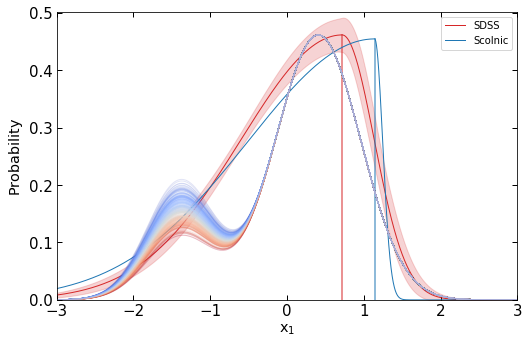

In [63]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSDSS.param['mu']

color_p = "C3"

pdf_SDSS = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSDSS.param['mu'],
                                  assymSDSS.param['sigma_m'],
                                  assymSDSS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SDSS,
        color=color_p,
        lw=1, label='SDSS')

ax.fill_between(x_linspace,
                pdf_SDSS + models_std_SDSS,
                pdf_SDSS - models_std_SDSS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSDSS.param['mu'], ymin=0, ymax=np.max(pdf_SDSS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = param_sco[0][0]
sigma_m_s = param_sco[0][1]
sigma_p_s = param_sco[0][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SDSS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SDSS'].zCMB, [0,100])

for z in surv['SDSS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SDSS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SDSS+models_std_SDSS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SDSS.pdf', bbox_inches='tight')

# SNLS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [46]:
cov_SNLS = im.Minuit.matrix(assymSNLS.m_tot)
mean_SNLS = [assymSNLS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SNLS = scipy.stats.multivariate_normal.rvs(mean=mean_SNLS, cov=cov_SNLS, size=500)

### List of all the models

In [47]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SNLS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SNLS]
models_hesse_SNLS = np.asarray(models_hesse_SNLS)

### Take _std_

In [48]:
models_std_SNLS = np.std(models_hesse_SNLS, axis=0)

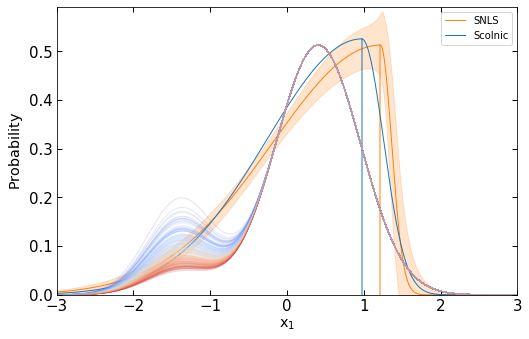

In [89]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSNLS.param['mu']

color_p = "C1"

pdf_SNLS = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSNLS.param['mu'],
                                  assymSNLS.param['sigma_m'],
                                  assymSNLS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SNLS,
        color=color_p,
        lw=1, label='SNLS')

ax.fill_between(x_linspace,
                pdf_SNLS + models_std_SNLS,
                pdf_SNLS - models_std_SNLS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSNLS.param['mu'], ymin=0, ymax=np.max(pdf_SNLS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = param_sco[2][0]
sigma_m_s = param_sco[2][1]
sigma_p_s = param_sco[2][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SNLS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SNLS'].zCMB, [0,100])

for z in surv['SNLS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SNLS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SNLS+models_std_SNLS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SNLS.pdf', bbox_inches='tight')

# Associated graph

In [280]:
with open('../Data/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(base.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - base.get_a(res_ALL['aa']))*res_ALL['mu_2']))

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(base.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-base.get_a(res_SNF['aa']))*res_SNF['mu_2']))

def delta(z):
    return stretchevol.MockEvol().delta(z)

In [21]:
p_sco = {'SDSS': [1.142, 1.652, 0.104],
         'PS1': [0.384, 0.987, 0.505],
         'SNLS': [0.974, 1.236, 0.283]}

def pdfS(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSDSS.param['mu'],
                                    assymSDSS.param['sigma_m'],
                                    assymSDSS.param['sigma_p'])

def pdfP(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymPS1.param['mu'],
                                    assymPS1.param['sigma_m'],
                                    assymPS1.param['sigma_p'])

def pdfN(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSNLS.param['mu'],
                                    assymSNLS.param['sigma_m'],
                                    assymSNLS.param['sigma_p'])

def pdfS_sco(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SDSS'][0],
                                    p_sco['SDSS'][1],
                                    p_sco['SDSS'][2])

def pdfP_sco(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['PS1'][0],
                                    p_sco['PS1'][1],
                                    p_sco['PS1'][2])

def pdfN_sco(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SNLS'][0],
                                    p_sco['SNLS'][1],
                                    p_sco['SNLS'][2])

In [33]:
z_linspace = np.linspace(0, 1.4, 3000)
x_linspace = np.linspace(-10, 10, 1e7)

xmean_asymSDSS = np.sum(x_linspace*pdfS(x_linspace))/np.sum(pdfS(x_linspace))
xmean_asymPS1 = np.sum(x_linspace*pdfP(x_linspace))/np.sum(pdfP(x_linspace))
xmean_asymSNLS = np.sum(x_linspace*pdfN(x_linspace))/np.sum(pdfN(x_linspace))

xmean_asymSDSS_sco = np.sum(x_linspace*pdfS_sco(x_linspace))/np.sum(pdfS_sco(x_linspace))
xmean_asymPS1_sco = np.sum(x_linspace*pdfP_sco(x_linspace))/np.sum(pdfP_sco(x_linspace))
xmean_asymSNLS_sco = np.sum(x_linspace*pdfN_sco(x_linspace))/np.sum(pdfN_sco(x_linspace))

zlin_SDSS = np.linspace(np.percentile(df_full[df_full['survey'] == 'SDSS'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'SDSS'].redshifts, [0, 100])[1],
                        2000)

zlin_PS1 = np.linspace(np.percentile(df_full[df_full['survey'] == 'PS1'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'PS1'].redshifts, [0, 100])[1],
                        2000)

zlin_SNLS = np.linspace(np.percentile(df_full[df_full['survey'] == 'SNLS'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'SNLS'].redshifts, [0, 100])[1],
                        2000)

fullz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [0, 100])

fullz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [0, 100])

fullz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [0, 100])

asz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [5, 95])
asz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [5, 95])
asz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [5, 95])

bsz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [16, 84])
bsz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [16, 84])
bsz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [16, 84])

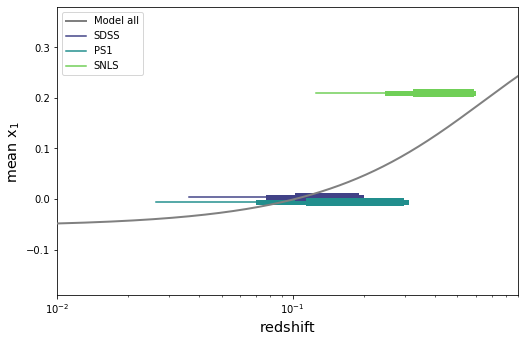

In [34]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.plot(z_linspace,
        age_law_all(z_linspace),
        color='0.5', lw=2, ls='-',
        label='Model all', zorder=6)

ax.plot(fullz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], label='SDSS')
ax.plot(fullz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], label='PS1')
ax.plot(fullz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], label='SNLS')

ax.plot(asz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], lw=5)
ax.plot(asz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], lw=5)
ax.plot(asz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], lw=5)

ax.plot(bsz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], lw=8)
ax.plot(bsz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], lw=8)
ax.plot(bsz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], lw=8)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.19, 0.38)
ax.set_xlim(0.01, 0.9)
ax.set_xscale('log')

ax.legend(ncol=1, loc='upper left')

fig.savefig('../../../Images/asym_BBC.pdf', bbox_inches='tight')

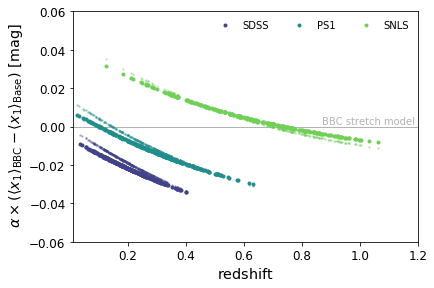

In [125]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.156

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_snf(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_snf(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_snf(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'], lw=2, ls='None', marker='.', alpha=.3, ms=3,zorder=6)

ax.hline(0, zorder=2, color="0.7", lw=1)

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_all(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'], lw=2, ls='None', marker='.',
        label=r'SDSS', zorder=6)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_all(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'], lw=2, ls='None', marker='.',
        label=r'PS1', zorder=6)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_all(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'], lw=2, ls='None', marker='.',
        label=r'SNLS', zorder=6)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag] ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.06, 0.06)
ax.set_xlim(0.01, 1.2)
#ax.set_xscale('log')

ax.legend(ncol=3, loc='upper right', frameon=False)

ax.tick_params(labelsize=12)

ax.text(0.99, 0.5, 'BBC stretch model',
        va='bottom', ha='right', transform=ax.transAxes,
        color='0.7')

fig.savefig('../../../Images/BBC_-stretchevol.pdf', bbox_inches='tight')

In [220]:
df_bias = df_full[df_full['survey'].isin(['PS1','SDSS','SNLS'])]

mean_bbc = {'SNLS': xmean_asymSNLS_sco,
            'SDSS': xmean_asymSDSS_sco,
            'PS1': xmean_asymPS1_sco}

def get_bias(df_line, alpha=0.156):
    meanBBC = mean_bbc[df_line.survey]
    meanBASE = age_law_all(df_line.redshifts)
    return(alpha*(meanBBC - meanBASE))

df_bias['bias'] = np.asarray([get_bias(df_bias.iloc[l]) for l in range(len(df_bias))])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [243]:
z_bin = np.linspace(0, 1.5, 30)
df_bias['zbin'] = np.digitize(df_bias.redshifts, z_bin)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [244]:
df_bias_grouped = df_bias.groupby('zbin').mean()

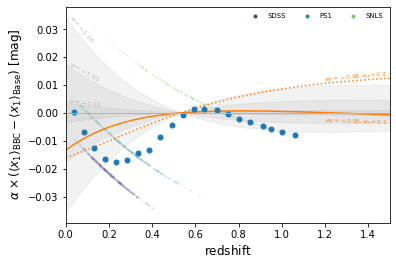

In [351]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

#ax.plot(df_bias.redshifts,
#        df_bias.bias, ls='None', marker='o')
prop=dict(lw=2, ls='None', marker='.', ms=4, alpha=.1, mew=0)

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_all(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'],
         **prop)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_all(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'],
         **prop)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_all(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'],
         **prop)

zz = 10**np.linspace(-3, 3, 100)
lcmd = astropy.cosmology.FlatwCDM(70, 0.30, w0=-1)
REFZ = 0.5
for w in [[-0.90, -1.10], [-0.95, -1.05],[-0.99, -1.01]]:
    deltaup = lcmd.distmod(zz) -astropy.cosmology.FlatwCDM(70, 0.30, w0=w[0]).distmod(zz)
    deltalow = lcmd.distmod(zz)-astropy.cosmology.FlatwCDM(70, 0.30, w0=w[1]).distmod(zz)
    ax.fill_between(zz,
                    deltaup-deltaup[np.argmin(np.abs(zz-REFZ))],
                    deltalow-deltalow[np.argmin(np.abs(zz-REFZ))],
                   color="0.5", alpha=0.1)

delta_ = lcmd.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.95, wa=-0.1).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C1')

delta_ = lcmd.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.98, wa=0.2).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C1', ls=':')

ax.plot(df_bias_grouped.redshifts,
        df_bias_grouped.bias, ls='None', marker='o',
        color='C0', ms=5)

ax.axhline(0, color="0.7", lw=1)
ax.set_xlim(0, 1.5)
#ax.set_xscale("log")

ax.text(0.01, 0.03, r'$w = -1.10$', color="0.7", fontsize='xx-small',
        rotation=-50, va='center', ha='left')
ax.text(0.01, 0.015, r'$w = -1.05$', color="0.7", fontsize='xx-small',
        rotation=-30, va='center', ha='left')
ax.text(0.01, 0.0035, r'$w = -1.01$', color="0.7", fontsize='xx-small',
        rotation=-7, va='center', ha='left')

xmax = ax.get_xlim()[-1]
ax.text(xmax-0.01, 0.013, r'$w_0=-0.98, w_a=0.2$', color="C1", fontsize='xx-small',
        rotation=5, va='center', ha='right')
ax.text(xmax-0.01, -0.003, r'$w_0=-0.95, w_a=0.1$', color="C1", fontsize='xx-small',
        rotation=-2, va='center', ha='right')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag] ", fontsize="large")

from matplotlib.lines import Line2D

SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='.')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='.')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='.')
labels = ['SDSS', 'PS1', 'SNLS']

ax.legend([SDSSleg, PS1leg, SNLSleg], labels,
           ncol=3, loc='upper right', frameon=False, fontsize='x-small')

fig.savefig('../../../Images/BBC_distmod.pdf', bbox_inches='tight')

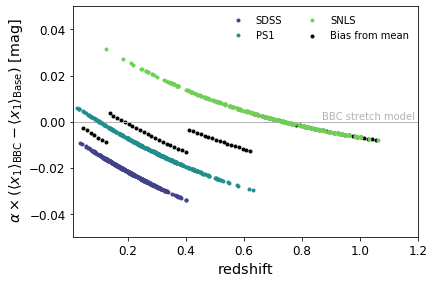

In [352]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.156

#ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
#        alpha*(xmean_asymSDSS_sco - age_law_snf(df_full[df_full['survey'] == 'SDSS'].redshifts)),
#        color=colors['SDSS'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)
#
#ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
#        alpha*(xmean_asymPS1_sco - age_law_snf(df_full[df_full['survey'] == 'PS1'].redshifts)),
#        color=colors['PS1'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)
#
#ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
#        alpha*(xmean_asymSNLS_sco - age_law_snf(df_full[df_full['survey'] == 'SNLS'].redshifts)),
#        color=colors['SNLS'], lw=2, ls='None', marker='.', alpha=.3, ms=3,zorder=6)

ax.hline(0, zorder=2, color="0.7", lw=1)

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_all(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'], lw=2, ls='None', marker='.',
        label=r'SDSS', zorder=6)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_all(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'], lw=2, ls='None', marker='.',
        label=r'PS1', zorder=6)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_all(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'], lw=2, ls='None', marker='.',
        label=r'SNLS', zorder=6)

z_tot = np.asarray(df_full[df_full['survey'].isin(['PS1','SDSS','SNLS'])].redshifts)
xbar = np.linspace(np.min(z_tot), np.max(z_tot), 80)

inf = {'SDSS': np.min(df_full[df_full['survey'] == 'SDSS'].redshifts),
       'PS1': np.min(df_full[df_full['survey'] == 'PS1'].redshifts),
       'SNLS': np.min(df_full[df_full['survey'] == 'SNLS'].redshifts)}

sup = {'SDSS': np.max(df_full[df_full['survey'] == 'SDSS'].redshifts),
       'PS1': np.max(df_full[df_full['survey'] == 'PS1'].redshifts),
       'SNLS': np.max(df_full[df_full['survey'] == 'SNLS'].redshifts)}

ybar = []
center_xbar = []
for i in range(len(xbar)-1):
    center_xbar.append(np.mean([xbar[i+1], xbar[i]]))
    if (center_xbar[i] > inf['PS1']) & (center_xbar[i] < inf['SDSS']):
        bbc_mean = xmean_asymPS1_sco - age_law_all(center_xbar[i])
    if (center_xbar[i] > inf['SDSS']) & (center_xbar[i] < inf['SNLS']):
        bbc_mean = (xmean_asymPS1_sco + xmean_asymSDSS_sco - 2*age_law_all(center_xbar[i]))/2
    if (center_xbar[i] > inf['SNLS']) & (center_xbar[i] < sup['SDSS']):
        bbc_mean = (xmean_asymPS1_sco + xmean_asymSDSS_sco + xmean_asymSNLS_sco - 3*age_law_all(center_xbar[i]))/3
    if (center_xbar[i] > sup['SDSS']) & (center_xbar[i] < sup['PS1']):
        bbc_mean = (xmean_asymPS1_sco + xmean_asymSNLS_sco - 2*age_law_all(center_xbar[i]))/2
    if (center_xbar[i] > sup['PS1']) & (center_xbar[i] < sup['SNLS']):
        bbc_mean = xmean_asymSNLS_sco - age_law_all(center_xbar[i])
    ybar.append(alpha*(bbc_mean))
    #ybar.append(alpha*(np.mean(df_used[where]) - age_law_all(np.mean(df_used[where]))))

ax.scatter(center_xbar,
           ybar,
           color='k', marker='.',
           label='Bias from mean')

#ax.scatter(center_xbar,
#           cosmo_base.distmod(center_xbar).value - cosmo_95.distmod(center_xbar).value,
#           alpha=.1, label=r'$\Delta\mu,\,\, w=-0.95$')
#
#ax.scatter(center_xbar,
#           cosmo_base.distmod(center_xbar).value - cosmo_99.distmod(center_xbar).value,
#           alpha=.1, label=r'$\Delta\mu,\,\, w=-0.99$')
#
#ax.scatter(center_xbar,
#           cosmo_base.distmod(center_xbar).value - cosmo_01.distmod(center_xbar).value,
#           alpha=.1, label=r'$\Delta\mu,\,\, w=-1.01$')
#
#ax.scatter(center_xbar,
#           cosmo_base.distmod(center_xbar).value - cosmo_05.distmod(center_xbar).value,
#           alpha=.1, label=r'$\Delta\mu,\,\, w=-1.05$')

#ax.vline(center_xbar, color='k')

#ax.scatter(z_tot, df_used, color='r')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag] ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.05, 0.05)
ax.set_xlim(0.01, 1.2)
#ax.set_xscale('log')

ax.legend(ncol=2, loc='upper right', frameon=False)

ax.tick_params(labelsize=12)

ax.text(0.99, 0.5, 'BBC stretch model',
        va='bottom', ha='right', transform=ax.transAxes,
        color='0.7')

fig.savefig('../../../Images/BBC-stretchevol_binned.pdf', bbox_inches='tight')

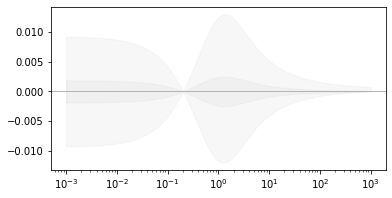

In [130]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111)
zz = 10**np.linspace(-3, 3, 100)
lcmd = astropy.cosmology.FlatwCDM(70, 0.30, w0=-1)
REFZ = 0.2
for w in [[-0.95, -1.05],[-0.99, -1.01]]:
    deltaup = lcmd.distmod(zz) -astropy.cosmology.FlatwCDM(70, 0.30, w0=w[0]).distmod(zz)
    deltalow = lcmd.distmod(zz)-astropy.cosmology.FlatwCDM(70, 0.30, w0=w[1]).distmod(zz)
    ax.fill_between(zz,
                    deltaup-deltaup[np.argmin(np.abs(zz-REFZ))],
                    deltalow-deltalow[np.argmin(np.abs(zz-REFZ))],
                   color="0.7", alpha=0.1)
ax.axhline(0, color="0.7", lw=1)
ax.set_xscale("log")

In [110]:
cosmo_base.distmod(center_xbar).value - cosmo_95.distmod(center_xbar).value

array([0.00179257, 0.00247149, 0.003132  , 0.00377446, 0.00439919,
       0.00500654, 0.00559685, 0.00617046, 0.0067277 , 0.00726892,
       0.00779445, 0.00830462, 0.00879976, 0.00928021, 0.00974629,
       0.01019833, 0.01063664, 0.01106155, 0.01147337, 0.01187241,
       0.01225898, 0.01263338, 0.01299592, 0.01334688, 0.01368656,
       0.01401525, 0.01433323, 0.01464077, 0.01493815, 0.01522564,
       0.01550349, 0.01577197, 0.01603134, 0.01628183, 0.0165237 ,
       0.01675718, 0.01698251, 0.0171999 , 0.0174096 , 0.01761181,
       0.01780675, 0.01799463, 0.01817565, 0.01835001, 0.01851791,
       0.01867953, 0.01883506, 0.01898468, 0.01912857, 0.01926689,
       0.01939982, 0.01952751, 0.01965013, 0.01976783, 0.01988075,
       0.01998906, 0.02009287, 0.02019234, 0.0202876 , 0.02037878,
       0.02046601, 0.02054941, 0.02062909, 0.02070518, 0.02077779,
       0.02084703, 0.020913  , 0.02097581, 0.02103556, 0.02109235,
       0.02114626, 0.02119741, 0.02124586, 0.02129171, 0.02133

In [106]:
cosmo_base = astropy.cosmology.LambdaCDM(H0 = Planck15.H0.value, Om0 = Planck15.Om0, Ode0 = Planck15.Ode0)
cosmo_95 = astropy.cosmology.wCDM(H0 = Planck15.H0.value, Om0 = Planck15.Om0, Ode0 = Planck15.Ode0, w0=-0.95)
cosmo_99 = astropy.cosmology.wCDM(H0 = Planck15.H0.value, Om0 = Planck15.Om0, Ode0 = Planck15.Ode0, w0=-0.99)
cosmo_01 = astropy.cosmology.wCDM(H0 = Planck15.H0.value, Om0 = Planck15.Om0, Ode0 = Planck15.Ode0, w0=-1.01)
cosmo_05 = astropy.cosmology.wCDM(H0 = Planck15.H0.value, Om0 = Planck15.Om0, Ode0 = Planck15.Ode0, w0=-1.05)

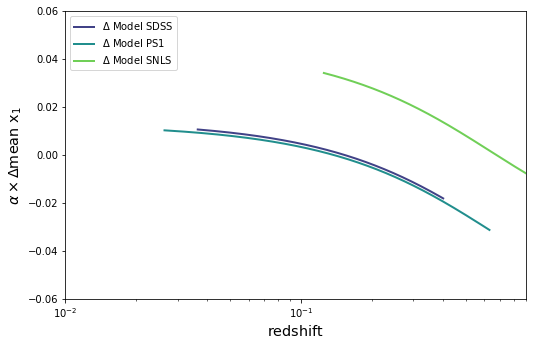

In [161]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.154

ax.plot(zlin_SDSS,
        alpha*(xmean_asymSDSS - age_law_snf(zlin_SDSS)),
        color=colors['SDSS'], lw=2, ls='-',
        label=r'$\Delta$ Model SDSS', zorder=6)

ax.plot(zlin_PS1,
        alpha*(xmean_asymPS1 - age_law_snf(zlin_PS1)),
        color=colors['PS1'], lw=2, ls='-',
        label=r'$\Delta$ Model PS1', zorder=6)

ax.plot(zlin_SNLS,
        alpha*(xmean_asymSNLS - age_law_snf(zlin_SNLS)),
        color=colors['SNLS'], lw=2, ls='-',
        label=r'$\Delta$ Model SNLS', zorder=6)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\alpha\times\Delta\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.06, 0.06)
ax.set_xlim(0.01, 0.9)
ax.set_xscale('log')

ax.legend(ncol=1, loc='upper left')

fig.savefig('../../../Images/US_-stretchevol.pdf', bbox_inches='tight')

## Get proba

In [11]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

In [12]:
modèles = [assymSNF, assymSDSS, assymPS1, assymSNLS, assymHST]

assym_comp = pd.DataFrame({'Assym': ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [round(k.migrad_out[1][1][2],2) for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [round(k.migrad_out[1][1][3],2) for k in modèles] + ['--'],
                           '$\sigma^+$': [round(k.migrad_out[1][2][2],2) for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [round(k.migrad_out[1][2][3],2) for k in modèles] + ['--'],
                           '$\mu^0$': [round(k.migrad_out[1][0][2],2) for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [round(k.migrad_out[1][0][3],2) for k in modèles] + ['--'],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles] + [round(np.sum([k.get_logl() for k in modèles]),1)],
                           'AICc': [round(k.get_aicc(),1) for k in modèles] + [round(np.sum([k.get_aicc() for k in modèles]),1)]})

path = '../Data/assym_comp'
if cons.value:
    path += '_cons'
path += '.dat'
assym_comp.to_csv(path)

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,$\mathcal{L}$,AICc
0,SNf,3,1.34,0.13,-0.41,0.1,0.68,0.15,299.3,305.5
1,SDSS,3,1.31,0.11,0.42,0.09,0.72,0.13,445.0,451.2
2,PS1,3,1.01,0.11,-0.52,0.12,0.38,0.16,397.4,403.6
3,SNLS,3,1.41,0.13,0.15,0.13,1.22,0.15,252.7,259.0
4,HST,3,0.76,0.36,0.79,0.35,0.11,0.44,73.7,80.8
5,Total,15,--,--,--,--,--,--,1468.2,1500.0


## Minimisation du modèle SNF et calcul $\mathcal{L}$ pour surveys

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df[df['survey'] == 'SDSS'])
baseSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'PS1'])
basePS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
baseSNLS = gen.fit()

In [18]:
models = [basePS1, baseSDSS, baseSNLS]

snf_comp = pd.DataFrame({'Base': ['SDSS', 'PS1', 'SNLS', 'Total'],
                         'Free param': [0 for k in models] + [0],
                         '$\mathcal{L}$': [round(k.get_logl(),1) for k in models] + [round(np.sum([k.get_logl() for k in models]),1)],
                         'AICc': [round(k.get_aicc(),1) for k in models] + [round(np.sum([k.get_aicc() for k in models]),1)]})

path = '../Data/snf_comp'
if cons.value:
    path += '_cons'
path += '.dat'
snf_comp.to_csv(path)

snf_comp

,Base,Free param,ln $\mathcal{L}$,AICc
0,SDSS,0,395.2,405.6
1,PS1,0,444.7,455.0
2,SNLS,0,254.1,264.7
3,Total,0,1094.0,1125.4
